In [26]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [27]:
from datetime import datetime

datetime.today().strftime('%Y-%m-%d %H:%M:%S')

'2024-09-27 12:28:55'

In [28]:
# make plot text bigger

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [29]:
plot_path = "/home/dschneidinger/cellar/DEREK2/MagShockZ_hdf5_chk_0005"
# plot_path = "/home/dschneidinger/cellar/OSIRIS_transfer/MAGON/MagShockZ_hdf5_chk_0005"

In [30]:
import sys
sys.path.append("../src")
from load_derived_FLASH_fields import derive_fields
ds = derive_fields(plot_path)

yt : [INFO     ] 2024-09-27 12:29:04,997 Particle file found: MagShockZ_hdf5_chk_0005
yt : [INFO     ] 2024-09-27 12:29:05,080 Parameters: current_time              = 1.975372613538229e-09
yt : [INFO     ] 2024-09-27 12:29:05,080 Parameters: domain_dimensions         = [384 544 384]
yt : [INFO     ] 2024-09-27 12:29:05,081 Parameters: domain_left_edge          = [-0.8   -0.075 -0.8  ]
yt : [INFO     ] 2024-09-27 12:29:05,081 Parameters: domain_right_edge         = [0.8 2.  0.8]
yt : [INFO     ] 2024-09-27 12:29:05,081 Parameters: cosmological_simulation   = 0


In [6]:
ds.domain_dimensions

array([288, 272, 288], dtype=int32)

In [7]:
mins = ds.domain_left_edge
maxs = ds.domain_right_edge
print(mins)
print(maxs)

[-0.6   -0.075 -0.6  ] code_length
[0.6 1.  0.6] code_length


In [33]:
# create covering grid from ds
level = 2
dims = ds.domain_dimensions * ds.refine_by**level

# We construct an object that describes the data region and structure we want
# In this case, we want all data up to the maximum "level" of refinement
# across the entire simulation volume.  Higher levels than this will not
# contribute to our covering grid.

all_data = ds.covering_grid(
    level,
    left_edge=ds.domain_left_edge,
    dims=dims,
    # And any fields to preload (this is optional!)
)
# density and electron temp at y=0
z_middle_index = dims[2] // 2
# dens = pd.DataFrame(all_data['flash', 'dens'][:, :, z_middle_index])
# tele = pd.DataFrame(all_data['flash', 'tele'][:, :, z_middle_index])

In [10]:
np_dens = dens.to_numpy()
dens_min = np_dens.min()
dens_max = np_dens.max()
print(dens_min, dens_max)

1.6940005791297807e-05 3.4888209269499812


In [11]:
extents = [mins[0], maxs[0], mins[1], maxs[1]]    # set extents of plot
time_pretty = round(current_time * 1e9, 1)        # get time in ns
print(extents)

[unyt_quantity(-0.6, 'code_length'), unyt_quantity(0.6, 'code_length'), unyt_quantity(-0.075, 'code_length'), unyt_quantity(1., 'code_length')]


In [12]:
ylimmin = 0.01    
ylimmax = 0.5    # we often have vacuum at the top so we want to set the plot y-axis maximum manually

In [6]:
plt.figure(figsize=(10,10))
im = plt.imshow(dens.T, norm=colors.LogNorm(), 
           cmap='plasma', origin='lower', extent=extents)
cbar = plt.colorbar(im, fraction=0.1, pad=0.04) # fraction and pad are for sizing the colorbar
cbar.set_label('mass density (g/$\mathregular{{cm}^3}$)')
plt.xlabel('r (cm)')
plt.ylabel('z (cm)')
plt.minorticks_on()
plt.xlim(0, extents[1])
plt.ylim(ylimmin, ylimmax)
plt.title("Mass density at t={} ns".format(time_pretty));
# plt.savefig("slice_mpl_{0}ns_{1}.png".format(time_pretty, datetime.today().strftime('%Y-%m-%d %H:%M:%S')), bbox_inches="tight")

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1022059/2696657589.py:5: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('mass density (g/$\mathregular{{cm}^3}$)')
/tmp/ipykernel_1022059/2696657589.py:5: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('mass density (g/$\mathregular{{cm}^3}$)')


NameError: name 'plt' is not defined

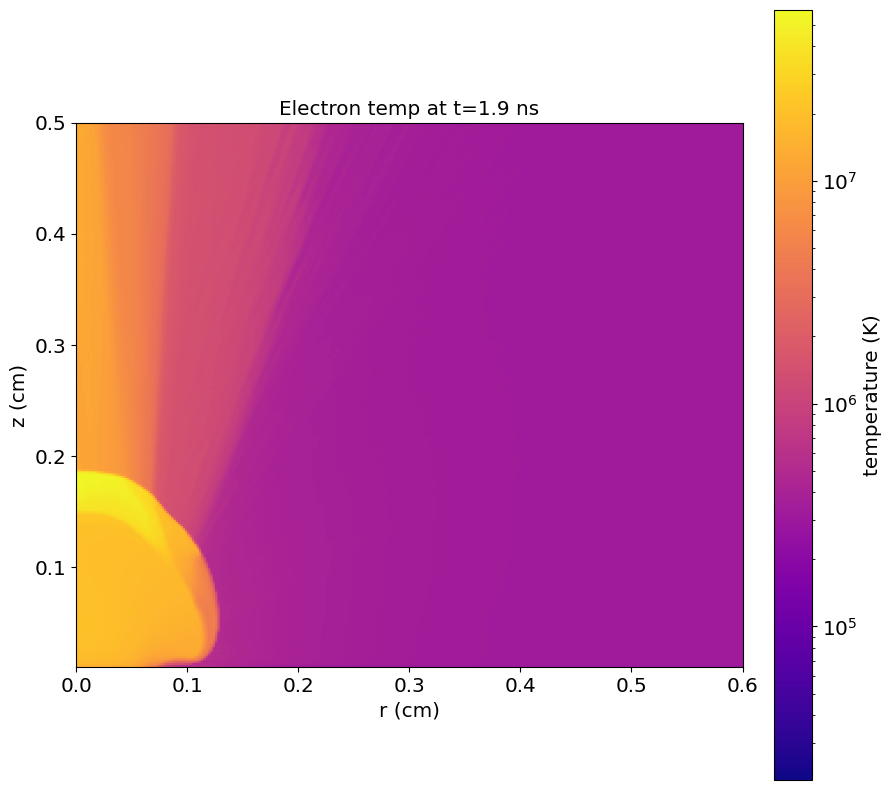

In [28]:
plt.figure(figsize=(10,10))
im = plt.imshow(tele.T, norm=colors.LogNorm(), 
           cmap='plasma', origin='lower', extent=extents)
cbar = plt.colorbar(im, fraction=0.1, pad=0.04)
cbar.set_label('temperature (K)')
plt.xlabel('r (cm)')
plt.ylabel('z (cm)')
plt.xlim(0, extents[1])
plt.ylim(ylimmin, ylimmax)
plt.title("Electron temp at t={} ns".format(time_pretty));
# plt.savefig("slice_mpl_{0}ns_{1}.png".format(time_pretty, datetime.today().strftime('%Y-%m-%d %H:%M:%S')), bbox_inches="tight")

yt : [INFO     ] 2024-09-27 13:16:53,498 xlim = -0.800000 0.800000
yt : [INFO     ] 2024-09-27 13:16:53,498 ylim = -0.075000 2.000000
yt : [INFO     ] 2024-09-27 13:16:53,499 xlim = -0.800000 0.800000
yt : [INFO     ] 2024-09-27 13:16:53,500 ylim = -0.075000 2.000000
yt : [INFO     ] 2024-09-27 13:16:53,500 Making a fixed resolution buffer of (('flash', 'edens')) 800 by 800
yt : [INFO     ] 2024-09-27 13:16:53,710 Saving plot ../results/FLASH_plots/edens_slice.png



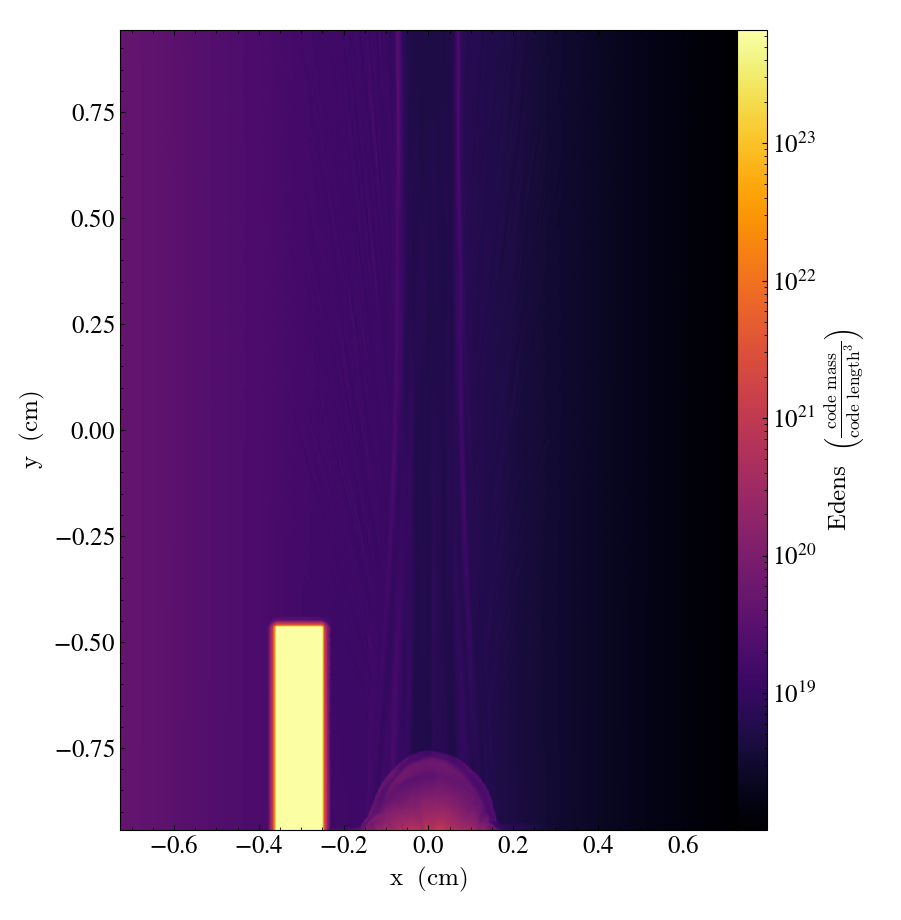

In [31]:
# you can get a very rough slice plot using the native yt plotter
slc = yt.SlicePlot(ds, "z", ("flash","edens")).zoom(1.1).set_cmap("edens","inferno")
slc.save("../results/FLASH_plots/edens_slice.png")
slc.show()

In [50]:
ds.field_list

[('flash', 'absr'),
 ('flash', 'cham'),
 ('flash', 'cond'),
 ('flash', 'dbgs'),
 ('flash', 'dens'),
 ('flash', 'depo'),
 ('flash', 'dfcf'),
 ('flash', 'divb'),
 ('flash', 'eele'),
 ('flash', 'eint'),
 ('flash', 'eion'),
 ('flash', 'emis'),
 ('flash', 'ener'),
 ('flash', 'erad'),
 ('flash', 'fllm'),
 ('flash', 'gamc'),
 ('flash', 'game'),
 ('flash', 'lase'),
 ('flash', 'magp'),
 ('flash', 'magx'),
 ('flash', 'magy'),
 ('flash', 'magz'),
 ('flash', 'mgdc'),
 ('flash', 'mgxo'),
 ('flash', 'mgyo'),
 ('flash', 'pele'),
 ('flash', 'pion'),
 ('flash', 'pipe'),
 ('flash', 'prad'),
 ('flash', 'pres'),
 ('flash', 'r001'),
 ('flash', 'res1'),
 ('flash', 'res2'),
 ('flash', 'shok'),
 ('flash', 'sumy'),
 ('flash', 'targ'),
 ('flash', 'tele'),
 ('flash', 'temp'),
 ('flash', 'tion'),
 ('flash', 'tite'),
 ('flash', 'trad'),
 ('flash', 'vac'),
 ('flash', 'velx'),
 ('flash', 'vely'),
 ('flash', 'velz'),
 ('flash', 'volx'),
 ('flash', 'voly'),
 ('flash', 'volz'),
 ('flash', 'ye')]

yt : [INFO     ] 2024-09-27 10:30:10,430 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-09-27 10:30:10,430 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-09-27 10:30:10,431 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-09-27 10:30:10,431 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-09-27 10:30:10,432 Making a fixed resolution buffer of (('flash', 'magp')) 800 by 800


yt : [INFO     ] 2024-09-27 10:30:10,831 Saving plot ../results/FLASH_plots/magx_slice.png



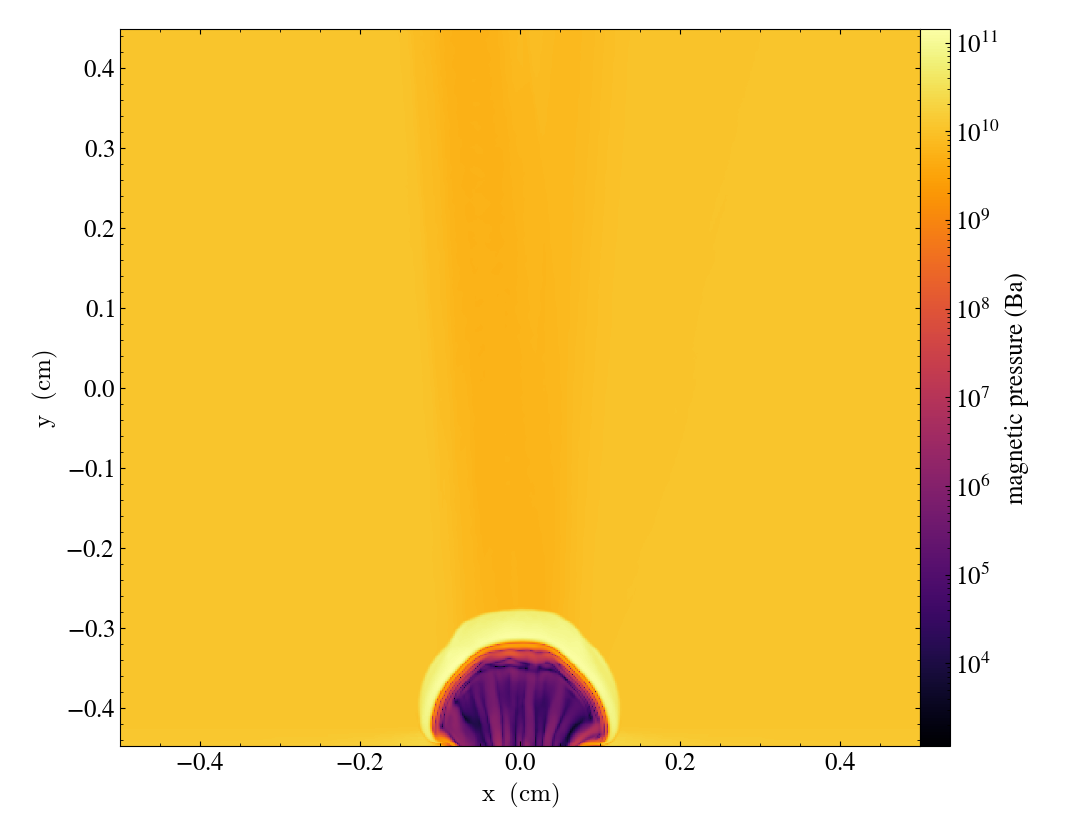

In [25]:
slc = yt.SlicePlot(ds, "z", ("flash","magp")).zoom(1.2).set_cmap("magp","inferno")
slc.set_colorbar_label("magp", "magnetic pressure (Ba)")
slc.save("../results/FLASH_plots/magx_slice.png")
slc.show()

yt : [INFO     ] 2024-09-27 10:28:09,505 xlim = -0.600000 0.600000


yt : [INFO     ] 2024-09-27 10:28:09,505 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-09-27 10:28:09,506 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-09-27 10:28:09,506 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-09-27 10:28:09,507 Making a fixed resolution buffer of (('flash', 'tele')) 800 by 800
yt : [INFO     ] 2024-09-27 10:28:09,644 Saving plot ../results/FLASH_plots/tele_slice.png



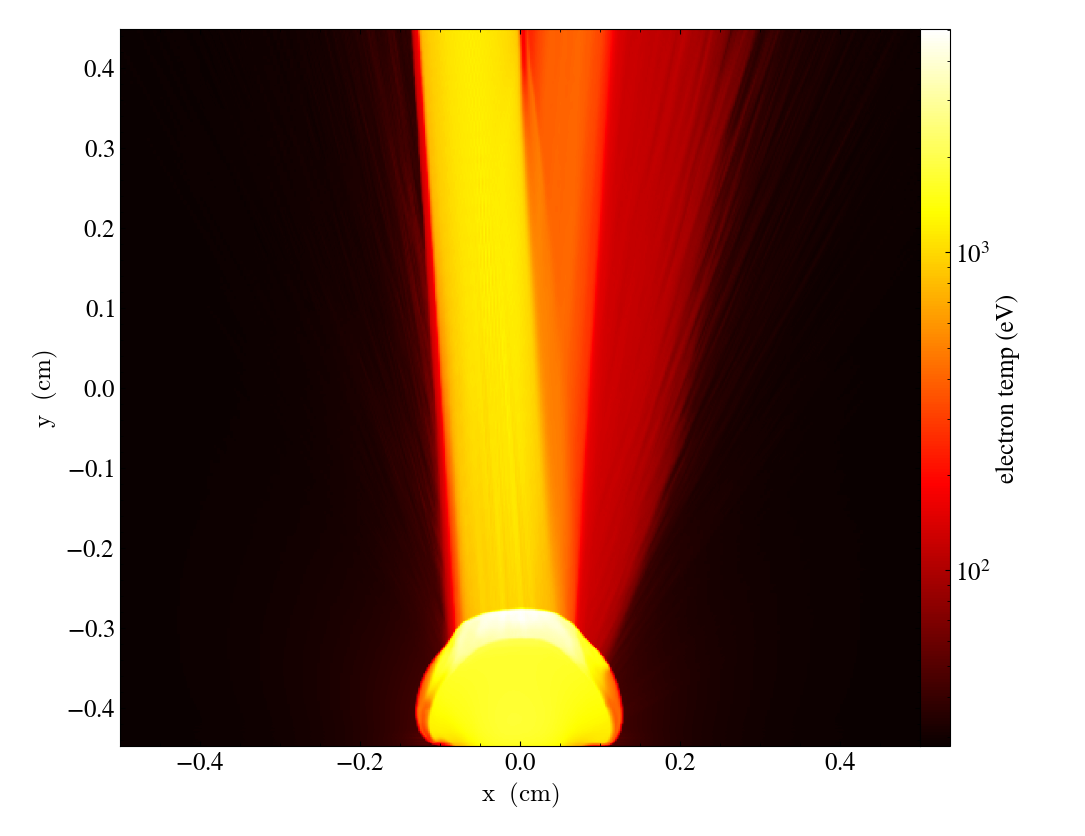

In [21]:
slc = yt.SlicePlot(ds, "z", ("flash","tele")).zoom(1.2).set_cmap("tele","hot")
kb = 8.617333262e-5
slc.frb["flash","tele"] *= kb
slc.set_colorbar_label("tele", "electron temp (eV)")
slc.save("../results/FLASH_plots/tele_slice.png")
slc.show()

yt : [INFO     ] 2024-09-27 10:28:03,088 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-09-27 10:28:03,089 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-09-27 10:28:03,090 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-09-27 10:28:03,090 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-09-27 10:28:03,090 Making a fixed resolution buffer of (('flash', 'tion')) 800 by 800


yt : [INFO     ] 2024-09-27 10:28:03,232 Saving plot ../results/FLASH_plots/tion_slice.png



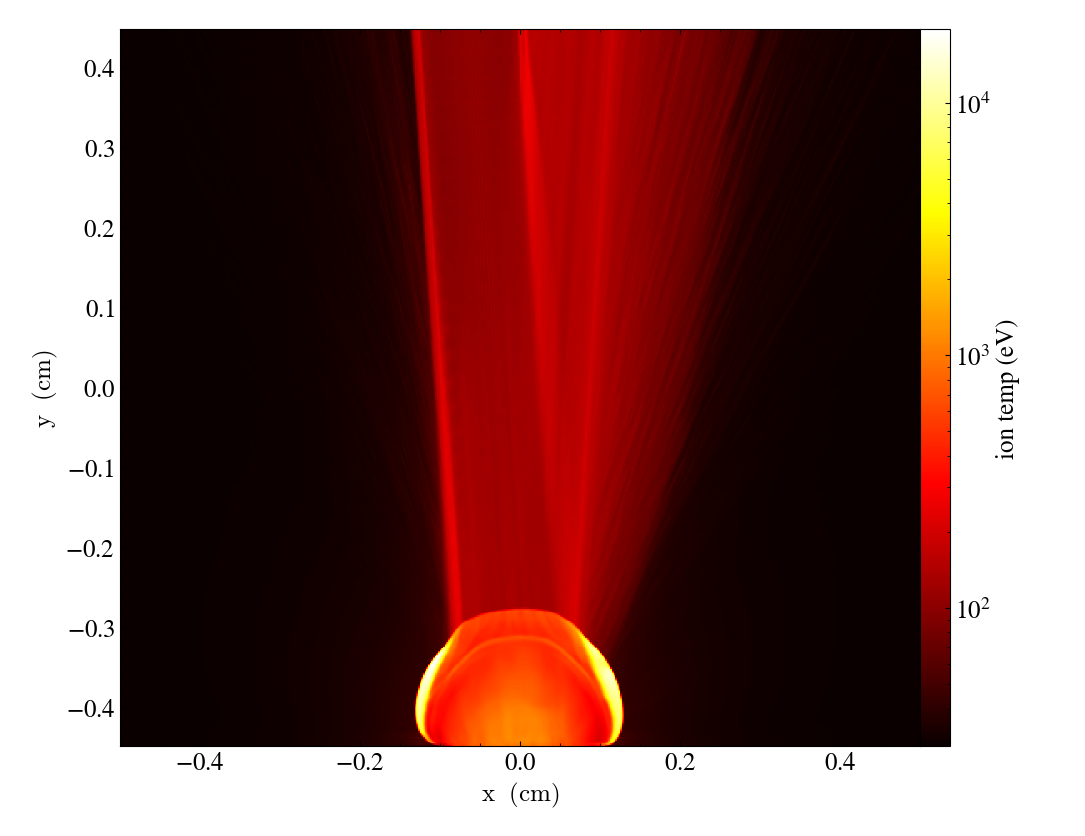

In [20]:
slc = yt.SlicePlot(ds, "z", ("flash","tion")).zoom(1.2).set_cmap("tion","hot")
kb = 8.617333262e-5
slc.frb["flash","tion"] *= kb
slc.set_colorbar_label("tion", "ion temp (eV)")
slc.save("../results/FLASH_plots/tion_slice.png")
slc.show()